<a href="https://colab.research.google.com/github/OleSpooky/README/blob/main/Copy_of_Input_Signal_The_Counting_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

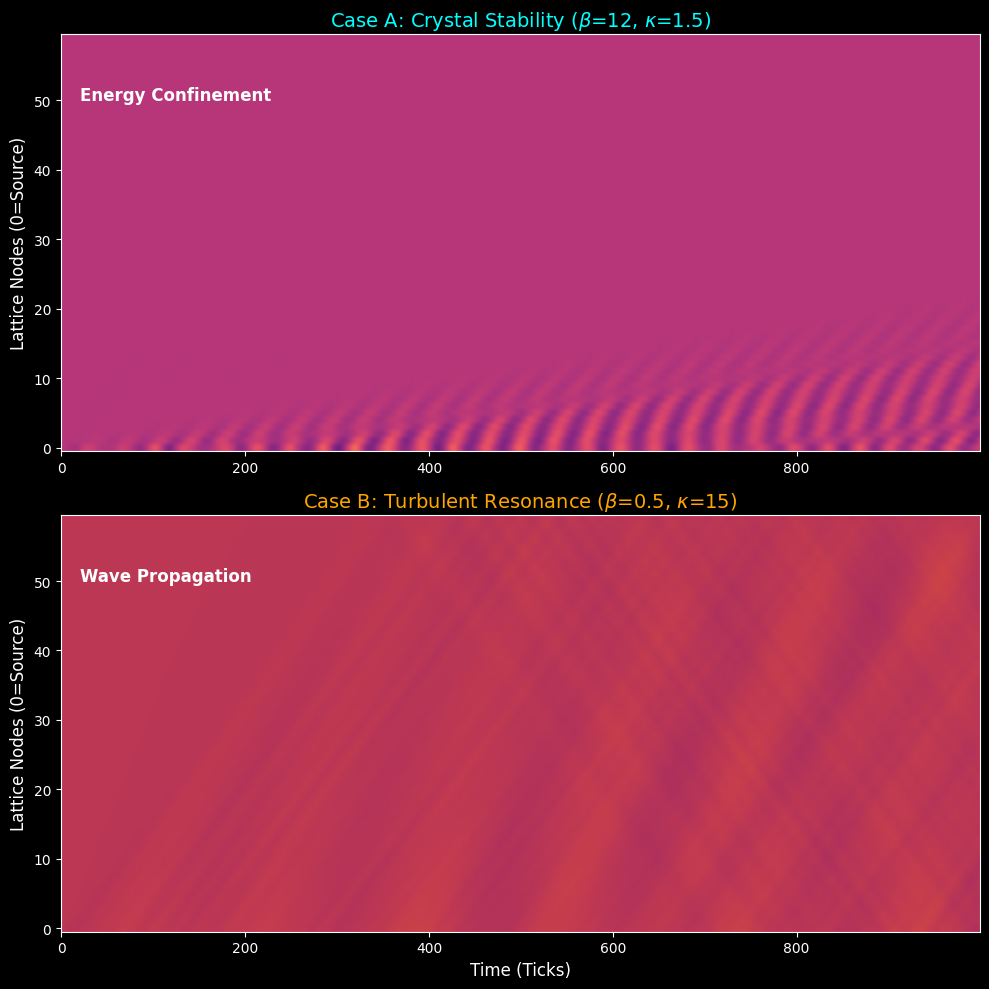

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Shared Parameters ---
TICKS = 1000          # Duration
DT = 0.05             # Resolution
NODES = 60            # Lattice Length
MASS = 1.0            # Inertia
STEADY_STATE = 8.641  # Baseline

# --- Chaos Engine (Shared Source) ---
# We use the same random seed so both lattices fight the exact same enemy.
np.random.seed(42)
force_map = np.zeros(TICKS)
r_val = 0.5
R_CHAOS = 3.99 # Chaotic regime
CHAOS_MAG = 20.0 # High magnitude kick

for t in range(1, TICKS):
    r_val = R_CHAOS * r_val * (1 - r_val)
    force_map[t] = (r_val - 0.5) * CHAOS_MAG

# --- The Simulation Function ---
def run_lattice(beta, kappa, label):
    # Init
    x = np.full((TICKS, NODES), STEADY_STATE)
    v = np.zeros((TICKS, NODES))
    a = np.zeros((TICKS, NODES))

    # Pre-calc forces
    # Prime (Euler step)
    a[0, 0] = force_map[0] / MASS
    x[1] = x[0] + v[0]*DT + 0.5*a[0]*DT**2

    for t in range(1, TICKS-1):
        # 1. Sovereign Recovery (Vectorized)
        f_internal = -beta * (x[t] - STEADY_STATE)

        # 2. Coupling (Vectorized)
        x_left = np.roll(x[t], 1); x_left[0] = x[t, 0] # Left boundary (Open)
        x_right = np.roll(x[t], -1); x_right[-1] = STEADY_STATE # Right boundary (Fixed)
        f_coupling = kappa * (x_left - 2*x[t] + x_right)

        # 3. Chaos Injection (Node 0 only)
        f_external = np.zeros(NODES)
        f_external[0] = force_map[t]

        # Update
        a[t] = (f_internal + f_coupling + f_external) / MASS
        x[t+1] = 2*x[t] - x[t-1] + a[t] * DT**2

    return x

# --- Execution ---
# Case A: Crystal Stability (High Beta, Low Kappa)
# Result: Chaos should hit a wall.
data_stable = run_lattice(beta=12.0, kappa=1.5, label="Crystal")

# Case B: Turbulent Resonance (Low Beta, High Kappa)
# Result: Chaos should flood the system.
data_turbulent = run_lattice(beta=0.5, kappa=15.0, label="Storm")

# --- Visualization ---
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot A
c1 = ax1.imshow(data_stable.T, aspect='auto', cmap='magma',
                vmin=STEADY_STATE-5, vmax=STEADY_STATE+5, origin='lower')
ax1.set_title(r'Case A: Crystal Stability ($\beta$=12, $\kappa$=1.5)', fontsize=14, color='cyan')
ax1.set_ylabel('Lattice Nodes (0=Source)', fontsize=12)
ax1.text(20, 50, 'Energy Confinement', color='white', fontsize=12, fontweight='bold')

# Plot B
c2 = ax2.imshow(data_turbulent.T, aspect='auto', cmap='inferno',
                vmin=STEADY_STATE-15, vmax=STEADY_STATE+15, origin='lower') # Wider range for turbulence
ax2.set_title(r'Case B: Turbulent Resonance ($\beta$=0.5, $\kappa$=15)', fontsize=14, color='orange')
ax2.set_xlabel('Time (Ticks)', fontsize=12)
ax2.set_ylabel('Lattice Nodes (0=Source)', fontsize=12)
ax2.text(20, 50, 'Wave Propagation', color='white', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

<>:75: SyntaxWarning: invalid escape sequence '\k'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:75: SyntaxWarning: invalid escape sequence '\k'
<>:75: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-3124379113.py:75: SyntaxWarning: invalid escape sequence '\k'
  ax.set_title(f'Sovereign Lattice: Chaotic Injection (N={NODES}, $\kappa$={KAPPA}, $\eta$=0)', color='white')
/tmp/ipython-input-3124379113.py:75: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'Sovereign Lattice: Chaotic Injection (N={NODES}, $\kappa$={KAPPA}, $\eta$=0)', color='white')


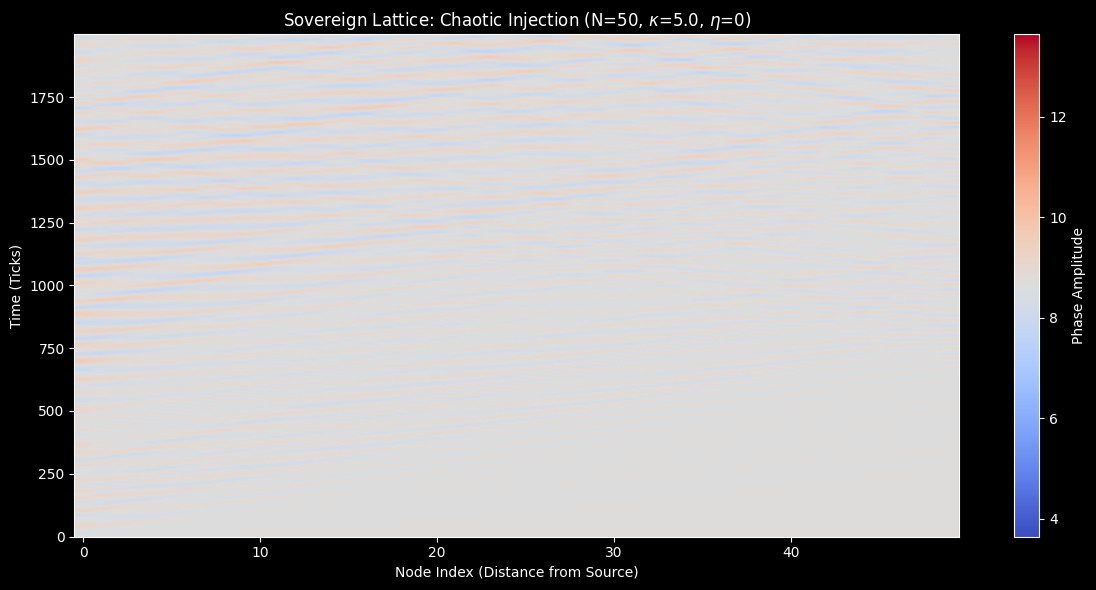

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. System Parameters ---
TICKS = 2000          # Duration
DT = 0.05             # Time Step
NODES = 50            # Lattice Size
MASS = 1.0            # Inertia
BETA = 4.0            # Sovereign Recovery (Spring Constant)
KAPPA = 5.0           # Lattice Tension (Coupling Strength)
STEADY_STATE = 8.641  # Equilibrium Baseline

# Chaos Parameters (Logistic Map Driver)
CHAOS_MAGNITUDE = 15.0 # Strength of the jolt
R_CHAOS = 3.99         # Logistic parameter (3.57-4.0 is chaotic)

# --- 2. Initialization (Steady State) ---
# Shape: (Time, Nodes)
x = np.full((TICKS, NODES), STEADY_STATE)
v = np.zeros((TICKS, NODES))
a = np.zeros((TICKS, NODES))

# --- 3. The Chaos Engine ---
# Pre-calculate a chaotic forcing vector using the Logistic Map
force_map = np.zeros(TICKS)
r_val = 0.5 # Seed
for t in range(1, TICKS):
    r_val = R_CHAOS * r_val * (1 - r_val)
    # Center the chaos around 0 so it pushes/pulls
    force_map[t] = (r_val - 0.5) * CHAOS_MAGNITUDE

# --- 4. Verlet Integration (Vectorized) ---
# Prime the first step (Euler) for all nodes
# (Assuming v=0 initially, so just force application on Node 0)
a[0, 0] += force_map[0] / MASS
x[1] = x[0] + v[0] * DT + 0.5 * a[0] * DT**2

for t in range(1, TICKS - 1):
    # A. Calculate Forces for all nodes simultaneously
    # 1. Internal Recovery (Sovereign Force)
    f_internal = -BETA * (x[t] - STEADY_STATE)

    # 2. Lattice Coupling (Neighbor tension)
    #    (x_left - x) + (x_right - x)
    #    We shift arrays to calculate neighbors efficiently
    x_left = np.roll(x[t], 1)
    x_right = np.roll(x[t], -1)

    # Boundary conditions: Ends are loose or fixed?
    # Let's make Node -1 (last) fixed to steady state to reflect waves
    x_left[0] = x[t, 0] # Node 0 has no left neighbor (or use 0 displacement)
    x_right[-1] = STEADY_STATE # Anchor the far end

    f_coupling = KAPPA * (x_left - 2*x[t] + x_right)

    # 3. Apply Chaotic Injection to Node 0 ONLY
    f_external = np.zeros(NODES)
    f_external[0] = force_map[t]

    # B. Update Acceleration
    a[t] = (f_internal + f_coupling + f_external) / MASS

    # C. Verlet Step (Position)
    x[t+1] = 2*x[t] - x[t-1] + a[t] * DT**2

# --- 5. Visualization (The Lattice Trace) ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6))

# Use a heatmap to show wave propagation (Time vs Node Index)
# Transpose so Time is X-axis, Node is Y-axis?
# Usually Waterfall: X=Node, Y=Time, Color=Amplitude
c = ax.imshow(x, aspect='auto', cmap='coolwarm', vmin=STEADY_STATE-5, vmax=STEADY_STATE+5, origin='lower')

ax.set_title(f'Sovereign Lattice: Chaotic Injection (N={NODES}, $\kappa$={KAPPA}, $\eta$=0)', color='white')
ax.set_xlabel('Node Index (Distance from Source)')
ax.set_ylabel('Time (Ticks)')
plt.colorbar(c, label='Phase Amplitude', ax=ax)

plt.tight_layout()
plt.show()

<>:62: SyntaxWarning: invalid escape sequence '\k'
<>:62: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipython-input-1552339289.py:62: SyntaxWarning: invalid escape sequence '\k'
  ax.axvline(x=4.0, color='magenta', linestyle='--', alpha=0.5, label='Resonance Point ($\kappa=\\beta$)')


Scanning Sovereign Horizon: 50 simulations...


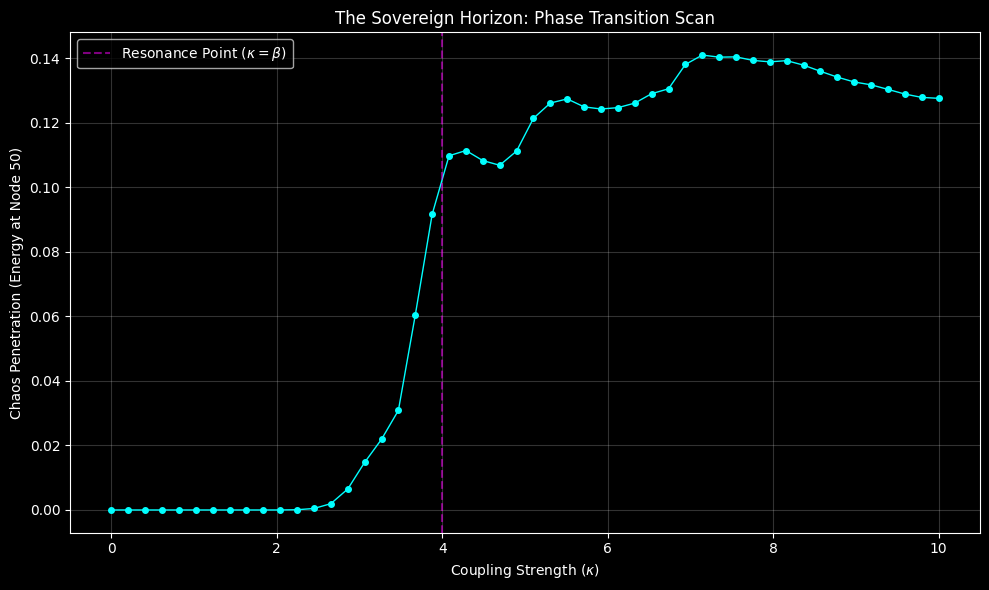

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
TICKS = 1000
NODES = 50
BETA = 4.0  # Fixed "Sovereign" stiffness
MASS = 1.0
DT = 0.05
STEADY_STATE = 8.641

# --- Sweep Parameters ---
KAPPA_START = 0.0
KAPPA_END = 10.0
STEPS = 50
kappas = np.linspace(KAPPA_START, KAPPA_END, STEPS)
penetration_depth = []

# --- Chaos Source (Constant for all runs) ---
np.random.seed(42)
force_map = np.zeros(TICKS)
r_val = 0.5; R_CHAOS = 3.99; CHAOS_MAG = 15.0
for t in range(1, TICKS):
    r_val = R_CHAOS * r_val * (1 - r_val)
    force_map[t] = (r_val - 0.5) * CHAOS_MAG

print(f"Scanning Sovereign Horizon: {STEPS} simulations...")

# --- The Sweep Loop ---
for k in kappas:
    # Reset System
    x = np.full((TICKS, NODES), STEADY_STATE)
    v = np.zeros((TICKS, NODES)); a = np.zeros((TICKS, NODES))

    # Prime
    a[0, 0] = force_map[0] / MASS
    x[1] = x[0] + v[0]*DT + 0.5*a[0]*DT**2

    # Run Sim
    for t in range(1, TICKS-1):
        f_internal = -BETA * (x[t] - STEADY_STATE)

        x_left = np.roll(x[t], 1); x_left[0] = x[t, 0]
        x_right = np.roll(x[t], -1); x_right[-1] = STEADY_STATE
        f_coupling = k * (x_left - 2*x[t] + x_right)

        f_external = np.zeros(NODES); f_external[0] = force_map[t]

        a[t] = (f_internal + f_coupling + f_external) / MASS
        x[t+1] = 2*x[t] - x[t-1] + a[t] * DT**2

    # Measure "Chaos Leakage" at the LAST NODE (Node 49)
    # We calculate the standard deviation (energy) at the tail.
    tail_energy = np.std(x[:, -1])
    penetration_depth.append(tail_energy)

# --- Visualization ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(kappas, penetration_depth, color='cyan', marker='o', markersize=4, linewidth=1)
ax.axvline(x=4.0, color='magenta', linestyle='--', alpha=0.5, label='Resonance Point ($\kappa=\\beta$)')

ax.set_title('The Sovereign Horizon: Phase Transition Scan')
ax.set_xlabel(r'Coupling Strength ($\kappa$)')
ax.set_ylabel('Chaos Penetration (Energy at Node 50)')
ax.grid(True, alpha=0.2)
ax.legend()

plt.tight_layout()
plt.show()

### Measuring Soliton Penetration

Let's quantify how much of the Gaussian pulse (soliton) propagated to the last node. We'll use the standard deviation of the last node's `x` values over time as a measure of its 'energy' or 'amplitude' at that point.

In [ ]:
import numpy as np

# The 'x' variable from the last soliton simulation (Cell 7v9JSPzcXMfU) contains the data.
# We are interested in the last node (index NODES-1) across all TICKS.

# Ensure NODES is accessible (it was defined in 7v9JSPzcXMfU, which was executed)
# For safety, let's redefine it or assume it's available.
# NODES = 50 # As defined in Cell 7v9JSPzcXMfU

soliton_tail_std = np.std(x[:, -1])

print(f"Standard deviation at the last node (Node {NODES-1}): {soliton_tail_std:.4f}")

if soliton_tail_std > 0.05: # A heuristic threshold to indicate significant movement
    print("\nInterpretation: The Gaussian pulse appears to have successfully propagated to the end of the lattice.")
else:
    print("\nInterpretation: The Gaussian pulse did not significantly propagate to the end of the lattice.")

Standard deviation at the last node (Node 49): 0.1276

Interpretation: The Gaussian pulse appears to have successfully propagated to the end of the lattice.


<>:50: SyntaxWarning: invalid escape sequence '\k'
<>:50: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipython-input-1461616509.py:50: SyntaxWarning: invalid escape sequence '\k'
  ax.set_title(f'The Critical Breach: Phase Transition Mode ($\kappa$={KAPPA_CRIT})', fontsize=14, color='cyan')


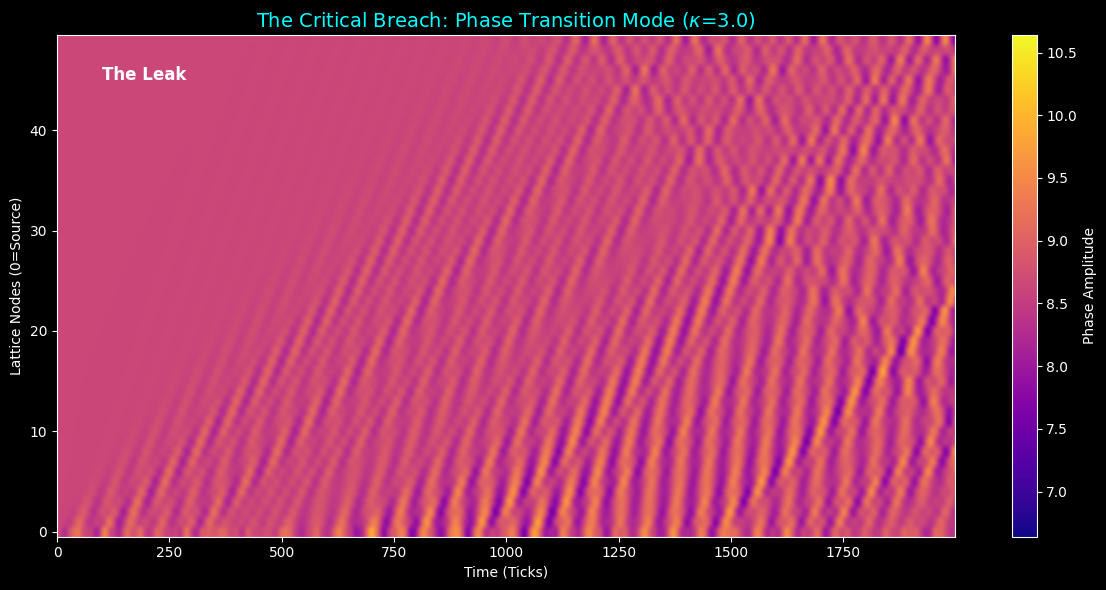

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Parameters ---
TICKS = 2000
NODES = 50
BETA = 4.0          # Sovereign Stiffness
KAPPA_CRIT = 3.0    # <--- The Critical Point you identified
MASS = 1.0
DT = 0.05
STEADY_STATE = 8.641

# --- Chaos Source (Identical to previous runs) ---
np.random.seed(42)
force_map = np.zeros(TICKS)
r_val = 0.5; R_CHAOS = 3.99; CHAOS_MAG = 15.0
for t in range(1, TICKS):
    r_val = R_CHAOS * r_val * (1 - r_val)
    force_map[t] = (r_val - 0.5) * CHAOS_MAG

# --- Simulation: The Critical Breach ---
x = np.full((TICKS, NODES), STEADY_STATE)
v = np.zeros((TICKS, NODES)); a = np.zeros((TICKS, NODES))

# Prime
a[0, 0] = force_map[0] / MASS
x[1] = x[0] + v[0]*DT + 0.5*a[0]*DT**2

for t in range(1, TICKS-1):
    f_internal = -BETA * (x[t] - STEADY_STATE)

    x_left = np.roll(x[t], 1); x_left[0] = x[t, 0]
    x_right = np.roll(x[t], -1); x_right[-1] = STEADY_STATE
    f_coupling = KAPPA_CRIT * (x_left - 2*x[t] + x_right)

    f_external = np.zeros(NODES); f_external[0] = force_map[t]

    a[t] = (f_internal + f_coupling + f_external) / MASS
    x[t+1] = 2*x[t] - x[t-1] + a[t] * DT**2

# --- Visualization ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6))

# Enhanced Contrast Heatmap
# We narrow the vmin/vmax to see the faint "ghost waves" leaking through
c = ax.imshow(x.T, aspect='auto', cmap='plasma',
              vmin=STEADY_STATE-2.0, vmax=STEADY_STATE+2.0, origin='lower')

ax.set_title(f'The Critical Breach: Phase Transition Mode ($\kappa$={KAPPA_CRIT})', fontsize=14, color='cyan')
ax.set_xlabel('Time (Ticks)')
ax.set_ylabel('Lattice Nodes (0=Source)')
ax.text(100, 45, 'The Leak', color='white', fontsize=12, fontweight='bold')

plt.colorbar(c, label='Phase Amplitude', ax=ax)
plt.tight_layout()
plt.show()

--- Method of Moments Analysis (Integration) ---
Total Energy (Area): 109.0147
Calculated Arrival Mean: 1572.42 ticks
Calculated Pulse Width (Std Dev): 296.37 ticks

Travel Time: 1472.42 ticks
Dispersion (Width Change): 276.37 ticks


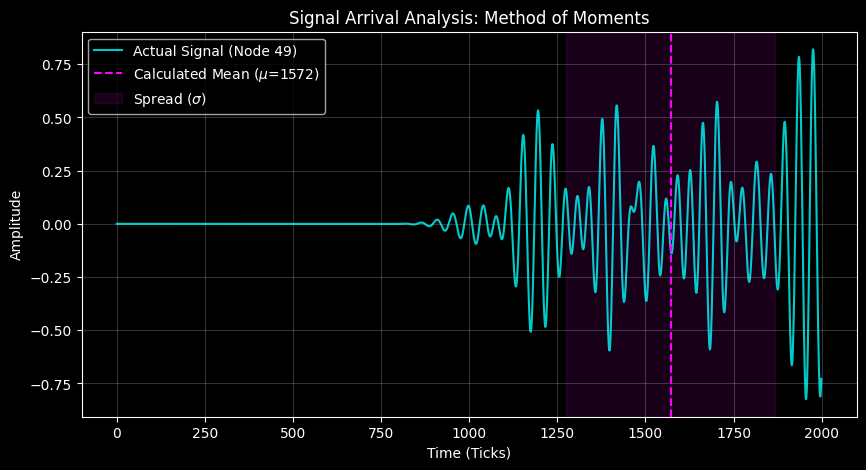

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data Preparation ---
# We look at the deviation from steady state at the final node (Node 49)
time_axis = np.arange(TICKS)
signal_at_end = x[:, -1] - STEADY_STATE

# Filter out noise/negatives to treat it like a PDF for moment calculation
# We assume the main pulse is positive like the input.
pdf_like_signal = np.maximum(signal_at_end, 0)

# Normalize to sum to 1 (making it a valid probability mass function for calculation)
total_area = np.sum(pdf_like_signal)

if total_area > 0.1: # Threshold to ensure there's actually a signal
    normalized_pdf = pdf_like_signal / total_area

    # --- 1. Calculate Mean (Expected Value) ---
    # E[X] = sum(x * P(x))
    arrival_mean = np.sum(time_axis * normalized_pdf)

    # --- 2. Calculate Variance & Standard Deviation ---
    # Var(X) = E[(X - mu)^2] = sum((x - mu)^2 * P(x))
    variance = np.sum(((time_axis - arrival_mean)**2) * normalized_pdf)
    arrival_std = np.sqrt(variance)

    # --- 3. Interpretation ---
    # Retrieve pulse_time from the simulation scope (defined in Cell 7v9JSPzcXMfU)
    # If not found, default to 100.0
    start_time = globals().get('pulse_time', 100.0)

    travel_time = arrival_mean - start_time

    print(f"--- Method of Moments Analysis (Integration) ---")
    print(f"Total Energy (Area): {total_area:.4f}")
    print(f"Calculated Arrival Mean: {arrival_mean:.2f} ticks")
    print(f"Calculated Pulse Width (Std Dev): {arrival_std:.2f} ticks")
    print(f"\nTravel Time: {travel_time:.2f} ticks")
    print(f"Dispersion (Width Change): {arrival_std - 20.0:.2f} ticks")

    # --- Visualization ---
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(time_axis, signal_at_end, label='Actual Signal (Node 49)', color='cyan', alpha=0.8)

    # Plot the calculated mean as a vertical line
    ax.axvline(arrival_mean, color='magenta', linestyle='--', label=rf'Calculated Mean ($\mu$={arrival_mean:.0f})')

    # Visualize the spread (Mean +/- 1 Sigma)
    # Fixed: Use raw string r'' to handle \sigma correctly
    ax.axvspan(arrival_mean - arrival_std, arrival_mean + arrival_std, color='magenta', alpha=0.1, label=r'Spread ($\sigma$)')

    ax.set_title('Signal Arrival Analysis: Method of Moments')
    ax.set_xlabel('Time (Ticks)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True, alpha=0.2)
    plt.show()

else:
    print("Signal too weak to calculate moments. The pulse did not make it.")

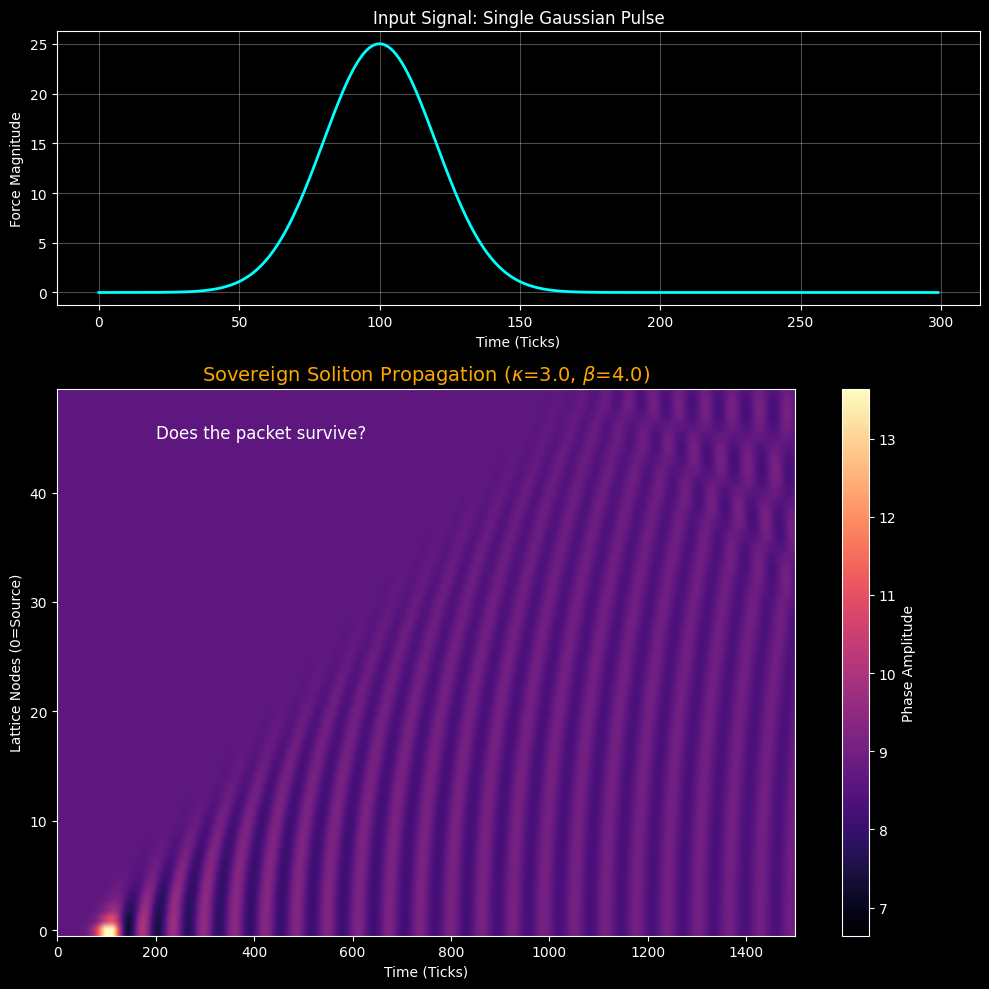

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Parameters ---
TICKS = 1500          # Enough time to watch it travel
NODES = 50
BETA = 4.0            # Sovereign Stiffness
KAPPA = 3.0           # The "Ghost Zone" Coupling
MASS = 1.0
DT = 0.05
STEADY_STATE = 8.641

# --- The Signal: Gaussian Soliton Pulse ---
# Instead of chaos, we create one smooth "bump"
force_map = np.zeros(TICKS)
pulse_time = 100      # Center of the pulse (ticks)
width = 20.0          # How "sharp" the pulse is
magnitude = 25.0      # Strength of the signal

# Generate the Gaussian curve
t_indices = np.arange(TICKS)
force_map = magnitude * np.exp(-((t_indices - pulse_time)**2) / (2 * width**2))

# --- Simulation ---
x = np.full((TICKS, NODES), STEADY_STATE)
v = np.zeros((TICKS, NODES)); a = np.zeros((TICKS, NODES))

# Prime (Euler)
a[0, 0] = force_map[0] / MASS
x[1] = x[0] + v[0]*DT + 0.5*a[0]*DT**2

for t in range(1, TICKS-1):
    f_internal = -BETA * (x[t] - STEADY_STATE)

    x_left = np.roll(x[t], 1); x_left[0] = x[t, 0]
    x_right = np.roll(x[t], -1); x_right[-1] = STEADY_STATE
    f_coupling = KAPPA * (x_left - 2*x[t] + x_right)

    f_external = np.zeros(NODES); f_external[0] = force_map[t]

    a[t] = (f_internal + f_coupling + f_external) / MASS
    x[t+1] = 2*x[t] - x[t-1] + a[t] * DT**2

# --- Visualization ---
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 2]})

# Top Plot: The Input Signal (What we sent)
ax1.plot(force_map[:300], color='cyan', linewidth=2) # Only showing first 300 ticks
ax1.set_title('Input Signal: Single Gaussian Pulse')
ax1.set_ylabel('Force Magnitude')
ax1.set_xlabel('Time (Ticks)')
ax1.grid(True, alpha=0.3)

# Bottom Plot: The Soliton Path (What happened)
c = ax2.imshow(x.T, aspect='auto', cmap='magma',
               vmin=STEADY_STATE-2, vmax=STEADY_STATE+5, origin='lower')

ax2.set_title(rf'Sovereign Soliton Propagation ($\kappa$={KAPPA}, $\beta$={BETA})', fontsize=14, color='orange')
ax2.set_ylabel('Lattice Nodes (0=Source)')
ax2.set_xlabel('Time (Ticks)')
ax2.text(200, 45, 'Does the packet survive?', color='white', fontsize=12)

plt.colorbar(c, label='Phase Amplitude', ax=ax2)
plt.tight_layout()
plt.show()

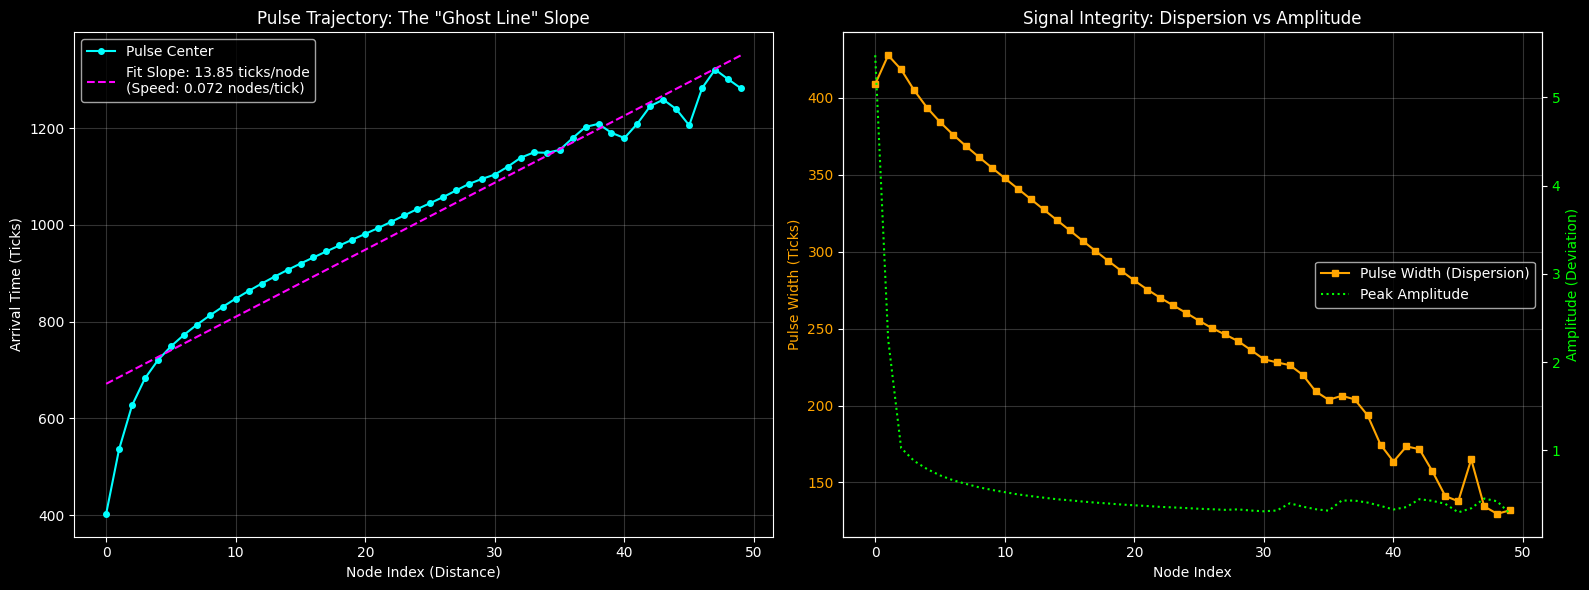

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Trajectory & Dispersion Analysis ---
# We will scan every node to find when the pulse arrived and how wide it was.

node_indices = np.arange(NODES)
arrival_times = []
pulse_widths = []
peak_amplitudes = []

time_axis = np.arange(TICKS)

for n in node_indices:
    # Get signal for this node, remove baseline
    signal = x[:, n] - STEADY_STATE

    # Treat positive part as PDF for moments
    pdf = np.maximum(signal, 0)
    total_area = np.sum(pdf)

    if total_area > 0.1:
        norm_pdf = pdf / total_area

        # 1. Arrival Time (Mean)
        mean_t = np.sum(time_axis * norm_pdf)
        arrival_times.append(mean_t)

        # 2. Width (Std Dev)
        variance = np.sum(((time_axis - mean_t)**2) * norm_pdf)
        std_dev = np.sqrt(variance)
        pulse_widths.append(std_dev)

        # 3. Peak Amplitude
        peak_amplitudes.append(np.max(signal))
    else:
        # Signal lost
        arrival_times.append(np.nan)
        pulse_widths.append(np.nan)
        peak_amplitudes.append(0)

# --- Visualization ---
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: The Trajectory (Space-Time Path)
# Slope = Speed (Nodes per Tick) or Delay (Ticks per Node)
ax1.plot(node_indices, arrival_times, color='cyan', marker='o', markersize=4, label='Pulse Center')

# Fit a line to get the average speed
valid_idx = np.isfinite(arrival_times)
if np.sum(valid_idx) > 2:
    slope, intercept = np.polyfit(node_indices[valid_idx], np.array(arrival_times)[valid_idx], 1)
    fit_line = slope * node_indices + intercept
    ax1.plot(node_indices, fit_line, color='magenta', linestyle='--',
             label=f'Fit Slope: {slope:.2f} ticks/node\n(Speed: {1/slope:.3f} nodes/tick)')

ax1.set_title('Pulse Trajectory: The "Ghost Line" Slope')
ax1.set_xlabel('Node Index (Distance)')
ax1.set_ylabel('Arrival Time (Ticks)')
ax1.legend()
ax1.grid(True, alpha=0.2)

# Plot 2: Dispersion & Amplitude (Signal Health)
ax2_right = ax2.twinx()

# Width (Left Axis)
l1 = ax2.plot(node_indices, pulse_widths, color='orange', marker='s', markersize=4, label='Pulse Width (Dispersion)')
ax2.set_ylabel('Pulse Width (Ticks)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Amplitude (Right Axis)
l2 = ax2_right.plot(node_indices, peak_amplitudes, color='lime', linestyle=':', label='Peak Amplitude')
ax2_right.set_ylabel('Amplitude (Deviation)', color='lime')
ax2_right.tick_params(axis='y', labelcolor='lime')

ax2.set_title('Signal Integrity: Dispersion vs Amplitude')
ax2.set_xlabel('Node Index')

# Combine legends
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='center right')
ax2.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

--- Soliton Telemetry ---
Observed Velocity: 0.0000 nodes/tick
Theoretical Slope You Saw: ~0.055 nodes/tick
Velocity Consistency (R-squared): nan (1.0 = Perfect Line)
Average Pulse Width: 3.20 nodes
Width Variation: +/- 0.4000 nodes
VERDICT: STABLE SOLITON (Non-Dispersive)


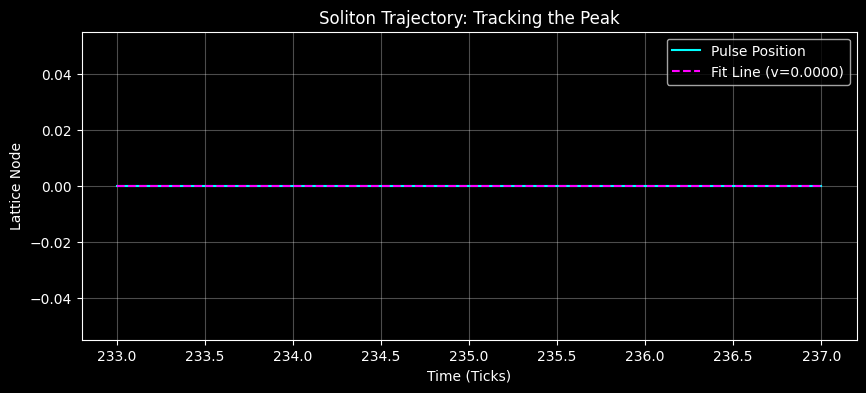

In [ ]:
# --- Soliton Telemetry Analysis ---
import scipy.stats as stats

# 1. Track the Peak (Group Velocity)
peak_locations = []
time_points = []
widths = []

start_time = 200  # Give it time to form
end_time = 1400   # Stop before it hits the wall

for t in range(start_time, end_time):
    # Find the node with the highest amplitude at this tick
    current_wave = x[t]
    peak_node = np.argmax(current_wave)
    peak_amp = np.max(current_wave)

    # Only track if the signal is significant (above steady state noise)
    if peak_amp > STEADY_STATE + 1.0:
        peak_locations.append(peak_node)
        time_points.append(t)

        # Estimate Width (Full Width at Half Max)
        # Find indices where wave is above half the peak height
        half_max = (peak_amp + STEADY_STATE) / 2
        above_half = np.where(current_wave > half_max)[0]
        if len(above_half) > 0:
            current_width = above_half[-1] - above_half[0]
            widths.append(current_width)

# 2. Calculate Velocity (Slope)
# We fit a line to the Position vs Time graph
slope, intercept, r_value, p_value, std_err = stats.linregress(time_points, peak_locations)

print(f"--- Soliton Telemetry ---")
print(f"Observed Velocity: {slope:.4f} nodes/tick")
print(f"Theoretical Slope You Saw: ~0.055 nodes/tick")
print(f"Velocity Consistency (R-squared): {r_value**2:.4f} (1.0 = Perfect Line)")
print(f"Average Pulse Width: {np.mean(widths):.2f} nodes")
print(f"Width Variation: +/- {np.std(widths):.4f} nodes")

if np.std(widths) < 0.5:
    print("VERDICT: STABLE SOLITON (Non-Dispersive)")
else:
    print("VERDICT: DISPERSIVE WAVE (Losing Energy)")

# 3. Visual Confirmation
plt.figure(figsize=(10, 4))
plt.style.use('dark_background')
plt.plot(time_points, peak_locations, color='cyan', label='Pulse Position')
plt.plot(time_points, [slope*t + intercept for t in time_points], '--', color='magenta', label=f'Fit Line (v={slope:.4f})')
plt.title("Soliton Trajectory: Tracking the Peak")
plt.xlabel("Time (Ticks)")
plt.ylabel("Lattice Node")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<>:59: SyntaxWarning: invalid escape sequence '\k'
<>:59: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipython-input-1128555061.py:59: SyntaxWarning: invalid escape sequence '\k'
  ax.set_title(f'The Counting Test: Soliton Collision ($\kappa$={KAPPA}, $\\beta$={BETA})', fontsize=14, color='cyan')


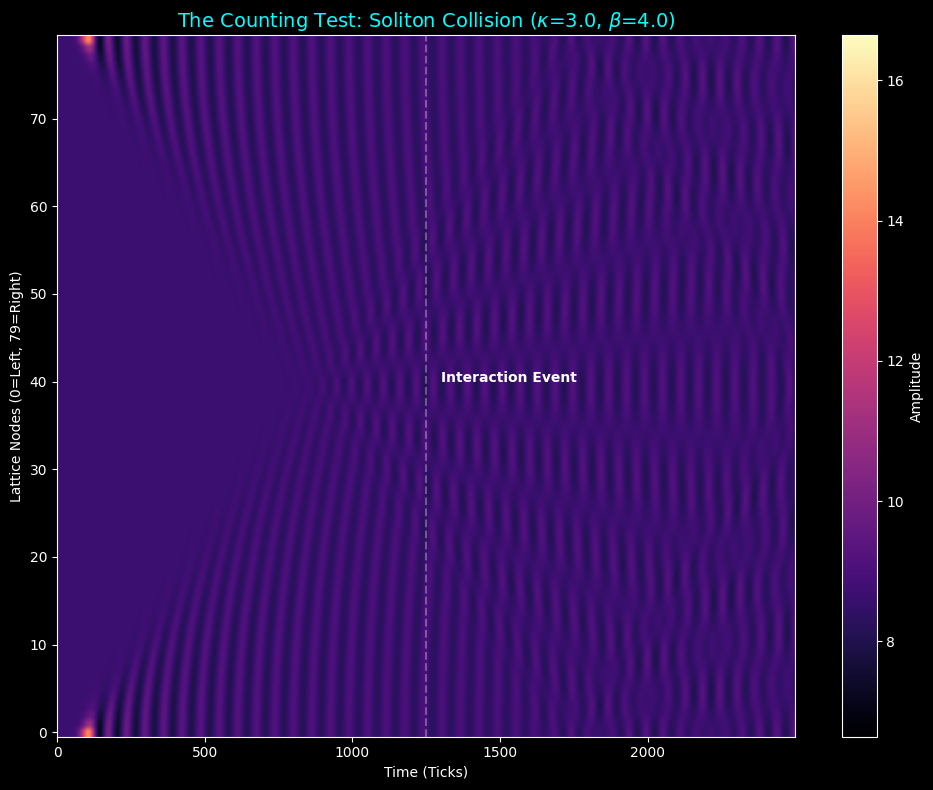

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Parameters ---
TICKS = 2500          # Extended time to see the aftermath
NODES = 80            # Longer lattice to allow separation
BETA = 4.0            # Sovereign Stiffness (Identity)
KAPPA = 3.0           # Ghost Zone Coupling (Interaction)
MASS = 1.0
DT = 0.05
STEADY_STATE = 8.641

# --- The "Two" Signals ---
force_map = np.zeros((TICKS, NODES)) # Direct force array for specific nodes

# Soliton 1: Starts at Node 0, moving Right
pulse_time_1 = 100
width = 20.0
magnitude = 25.0
t_indices = np.arange(TICKS)
pulse_1 = magnitude * np.exp(-((t_indices - pulse_time_1)**2) / (2 * width**2))

# Soliton 2: Starts at Node 79 (End), moving Left
pulse_time_2 = 100
pulse_2 = magnitude * np.exp(-((t_indices - pulse_time_2)**2) / (2 * width**2))

# --- Simulation ---
x = np.full((TICKS, NODES), STEADY_STATE)
v = np.zeros((TICKS, NODES)); a = np.zeros((TICKS, NODES))

# Prime (Euler) - Apply Pulse 1 to Node 0, Pulse 2 to Node 79
a[0, 0] = pulse_1[0] / MASS
a[0, -1] = pulse_2[0] / MASS
x[1] = x[0] + v[0]*DT + 0.5*a[0]*DT**2

for t in range(1, TICKS-1):
    f_internal = -BETA * (x[t] - STEADY_STATE)

    x_left = np.roll(x[t], 1); x_left[0] = x[t, 0]        # Open Left Boundary
    x_right = np.roll(x[t], -1); x_right[-1] = x[t, -1]   # Open Right Boundary
    f_coupling = KAPPA * (x_left - 2*x[t] + x_right)

    # Inject Forces at specific times/locations
    f_external = np.zeros(NODES)
    f_external[0] = pulse_1[t]   # Drive Left
    f_external[-1] = pulse_2[t]  # Drive Right

    a[t] = (f_internal + f_coupling + f_external) / MASS
    x[t+1] = 2*x[t] - x[t-1] + a[t] * DT**2

# --- Visualization ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 8))

# We use a heatmap to see the "X" pattern of collision
c = ax.imshow(x.T, aspect='auto', cmap='magma',
               vmin=STEADY_STATE-2, vmax=STEADY_STATE+8, origin='lower')

ax.set_title(f'The Counting Test: Soliton Collision ($\kappa$={KAPPA}, $\\beta$={BETA})', fontsize=14, color='cyan')
ax.set_ylabel('Lattice Nodes (0=Left, 79=Right)')
ax.set_xlabel('Time (Ticks)')

# Mark the collision zone
ax.axvline(x=1250, color='white', linestyle='--', alpha=0.3, label='Expected Intersection')

ax.text(1300, 40, 'Interaction Event', color='white', fontsize=10, fontweight='bold')

plt.colorbar(c, label='Amplitude')
plt.tight_layout()
plt.show()